In [1]:
import numpy as np
import nibabel as nib
import dipy.reconst.dti as dti
from dipy.data import fetch_stanford_hardi
fetch_stanford_hardi()
from dipy.data import read_stanford_hardi

Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 


In [11]:
%matplotlib inline
from dipy.reconst.dti import fractional_anisotropy, color_fa
from argparse import ArgumentParser
from scipy import ndimage
import os
import re
import numpy as np
import nibabel as nb
import sys
import matplotlib

# matplotlib.use('Agg')  # very important above pyplot import
import matplotlib.pyplot as plt

In [2]:
img, gtab = read_stanford_hardi()
data = img.get_data()
print('data.shape (%d, %d, %d, %d)' % data.shape)

Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 
data.shape (81, 106, 76, 160)


In [3]:
from dipy.segment.mask import median_otsu
maskdata, mask = median_otsu(data, 3, 1, True,
                             vol_idx=range(10, 50), dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

/usr/local/lib/python2.7/dist-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


maskdata.shape (71, 87, 62, 160)


In [4]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

In [5]:
print('Computing anisotropy measures (FA, MD, RGB)')
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy measures (FA, MD, RGB)


In [6]:
FA[np.isnan(FA)] = 0

In [7]:
FA.shape

(71, 87, 62)

In [12]:
def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :], 90)
            else:
                image = im[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig

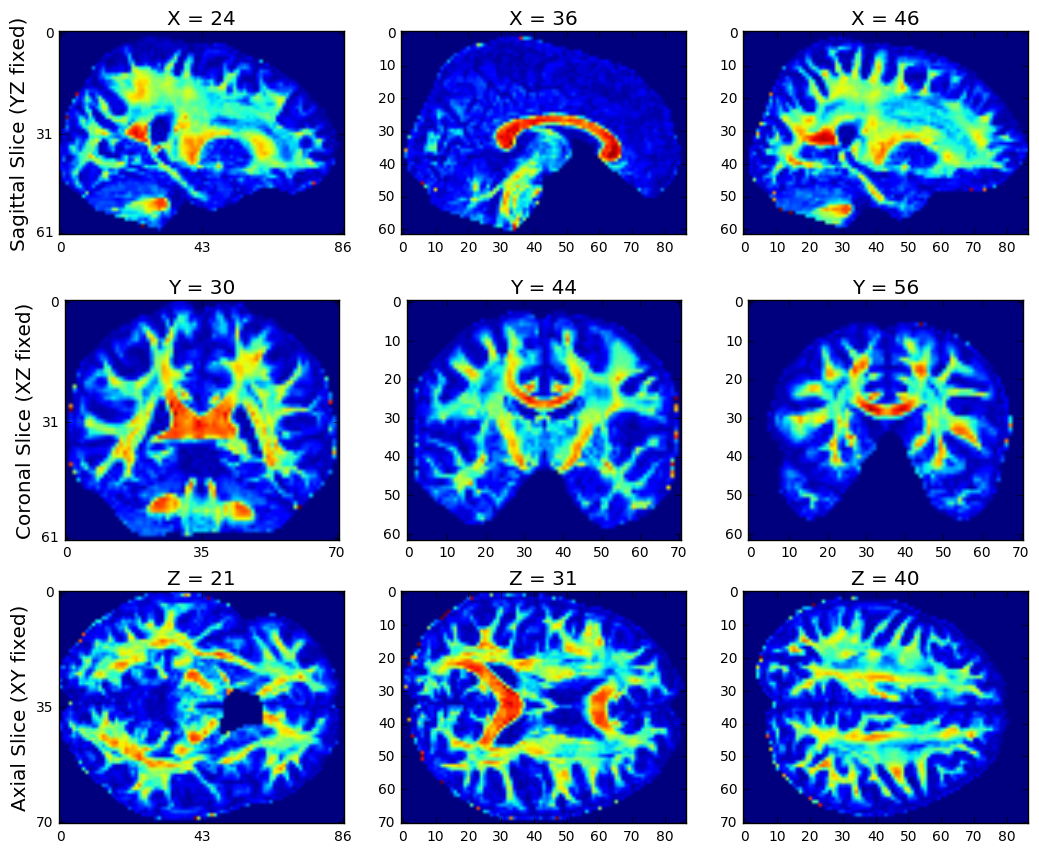

In [13]:
fig = plot_rgb(FA)

In [14]:
fa_img = nib.Nifti1Image(FA.astype(np.float32), img.affine)
nib.save(fa_img, 'tensor_fa.nii.gz')

In [15]:
fa_img.get_data().shape

(71, 87, 62)

In [16]:
evecs_img = nib.Nifti1Image(tenfit.evecs.astype(np.float32), img.affine)
nib.save(evecs_img, 'tensor_evecs.nii.gz')

In [17]:
evecs_img.get_data().shape

(71, 87, 62, 3, 3)

In [18]:
MD1 = dti.mean_diffusivity(tenfit.evals)
nib.save(nib.Nifti1Image(MD1.astype(np.float32), img.affine), 'tensors_md.nii.gz')

In [19]:
MD1.shape

(71, 87, 62)

In [20]:
MD2 = tenfit.md

In [21]:
MD2.shape

(71, 87, 62)

In [22]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
nib.save(nib.Nifti1Image(np.array(255 * RGB, 'uint8'), img.affine), 'tensor_rgb.nii.gz')

In [23]:
print FA.shape, RGB.shape

(71, 87, 62) (71, 87, 62, 3)


In [24]:
print('Computing tensor ellipsoids in a part of the splenium of the CC')

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()

evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

Computing tensor ellipsoids in a part of the splenium of the CC


In [25]:
print evals.shape, evecs.shape

(30, 30, 1, 3) (30, 30, 1, 3, 3)


In [ ]:
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))

print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids.png', size=(600, 600))

In [ ]:
print cfa.shape

In [ ]:
fvtk.clear(ren)

tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, colormap=None))
fvtk.show(ren)
print('Saving illustration as tensor_odfs.png')
fvtk.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))

## Tractography





In [26]:
fa_img = nib.load('tensor_fa.nii.gz')
FA = fa_img.get_data()
evecs_img = nib.load('tensor_evecs.nii.gz')
evecs = evecs_img.get_data()

In [27]:
print FA.shape, evecs.shape

(71, 87, 62) (71, 87, 62, 3, 3)


In [28]:
print FA.astype('f8').shape

(71, 87, 62)


In [29]:
FA[np.isnan(FA)] = 0
from dipy.data import get_sphere

sphere = get_sphere('symmetric724')
from dipy.reconst.dti import quantize_evecs

peak_indices = quantize_evecs(evecs, sphere.vertices)

from dipy.tracking.eudx import EuDX

eu = EuDX(FA.astype('f8'), peak_indices, seeds=50000, odf_vertices = sphere.vertices, a_low=0.2)

tensor_streamlines = [streamline for streamline in eu]

9898


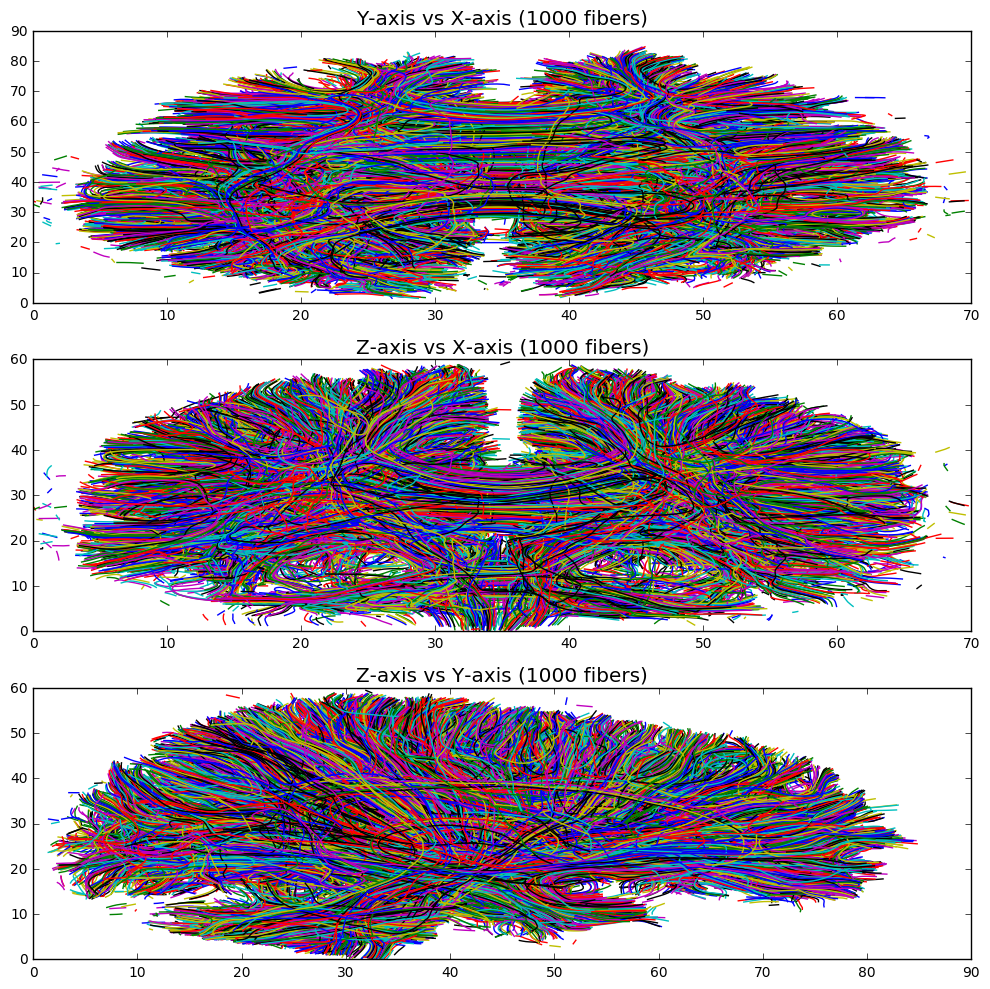

In [33]:
test = tensor_streamlines
print len(test)
plt.figure(1)
plt.subplots(figsize=(10, 10))
plt.subplot(311)
plt.title("Y-axis vs X-axis (1000 fibers)")
for i in range(len(test)):
    plt.plot(test[i][:,0], test[i][:,1])
plt.subplot(312)
plt.title("Z-axis vs X-axis (1000 fibers)")
for i in range(len(test)):
    plt.plot(test[i][:,0], test[i][:,2])
plt.subplot(313)
plt.title("Z-axis vs Y-axis (1000 fibers)")
for i in range(len(test)):
    plt.plot(test[i][:,1], test[i][:,2])
plt.tight_layout()
plt.show()

In [30]:
hdr = nib.trackvis.empty_header()
hdr['voxel_size'] = fa_img.get_header().get_zooms()[:3]
hdr['voxel_order'] = 'LAS'
hdr['dim'] = FA.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  from ipykernel import kernelapp as app


In [31]:
tensor_streamlines_trk = ((sl, None, None) for sl in tensor_streamlines)

ten_sl_fname = 'tensor_streamlines.trk'

In [ ]:
nib.trackvis.write(ten_sl_fname, tensor_streamlines_trk, hdr, points_space='voxel')

In [ ]:
ren = fvtk.ren()
from dipy.viz.colormap import line_colors
fvtk.add(ren, fvtk.streamtube(tensor_streamlines, line_colors(tensor_streamlines)))

print('Saving illustration as tensor_tracks.png')

ren.SetBackground(1, 1, 1)
fvtk.record(ren, n_frames=1, out_path='tensor_tracks.png', size=(600, 600))

In [ ]:
fvtk.show(ren)